In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf


In [2]:
import pandas as pd
df = pd.read_parquet('../paquets/data_weather.parquet', engine='pyarrow')

### Effet global de la météo sur la gravité des accidents (ANOVA)

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Reduce categories for clarity
top_weather = df['Weather'].value_counts().head(8).index
df_weather = df[df['Weather'].isin(top_weather)]

anova_sample = df_weather.sample(300_000)

model = ols('Severity ~ C(Weather)', data=anova_sample).fit()
sm.stats.anova_lm(model, typ=2)


,sum_sq,df,F,PR(>F)
C(Weather),2240.661175,7.0,1326.765157,0.0
Residual,72375.864571,299992.0,NaN,NaN


L’ANOVA montre une différence statistiquement significative de la gravité des accidents selon les conditions météorologiques (p < 0,05).
Cela confirme que la météo influence significativement la sévérité des accidents.

### Gravité médiane selon les principales conditions météorologiques (Boxplot)

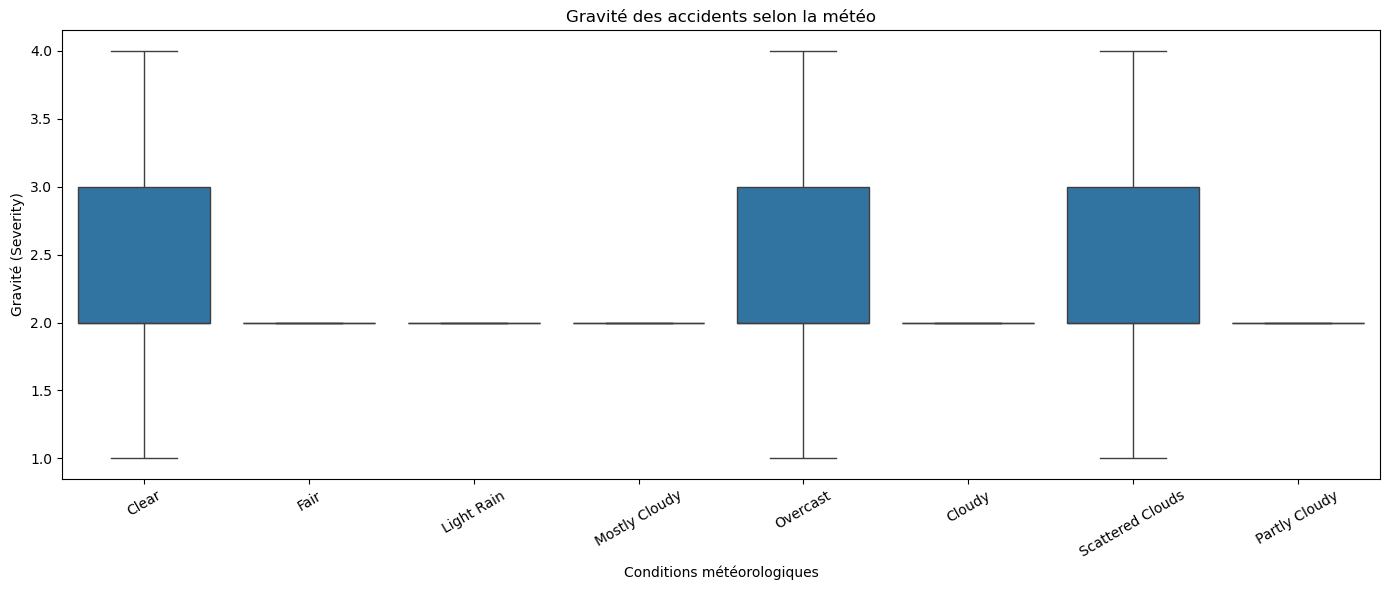

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.boxplot(
    data=df_weather.sample(200_000),
    x='Weather',
    y='Severity',
    showfliers=False
)
plt.title("Gravité des accidents selon la météo")
plt.xlabel("Conditions météorologiques")
plt.ylabel("Gravité (Severity)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Les boxplots révèlent que certaines conditions météorologiques présentent une gravité médiane plus élevée et une dispersion plus importante, traduisant un risque accru d’accidents sévères.


### Variabilité de la distance impactée selon la météo (Kruskal-Wallis)


In [13]:
from scipy.stats import kruskal

groups = [
    g['Distance'].dropna()
    for _, g in df_weather.groupby('Weather')
]

kruskal(*groups)


KruskalResult(statistic=273279.439684186, pvalue=0.0)

Le test de Kruskal-Wallis indique une différence significative de la distance impactée selon la météo (p < 0,05).
Les conditions défavorables entraînent des perturbations du trafic plus étendues.

### Distance impactée par la météo (Boxplot)

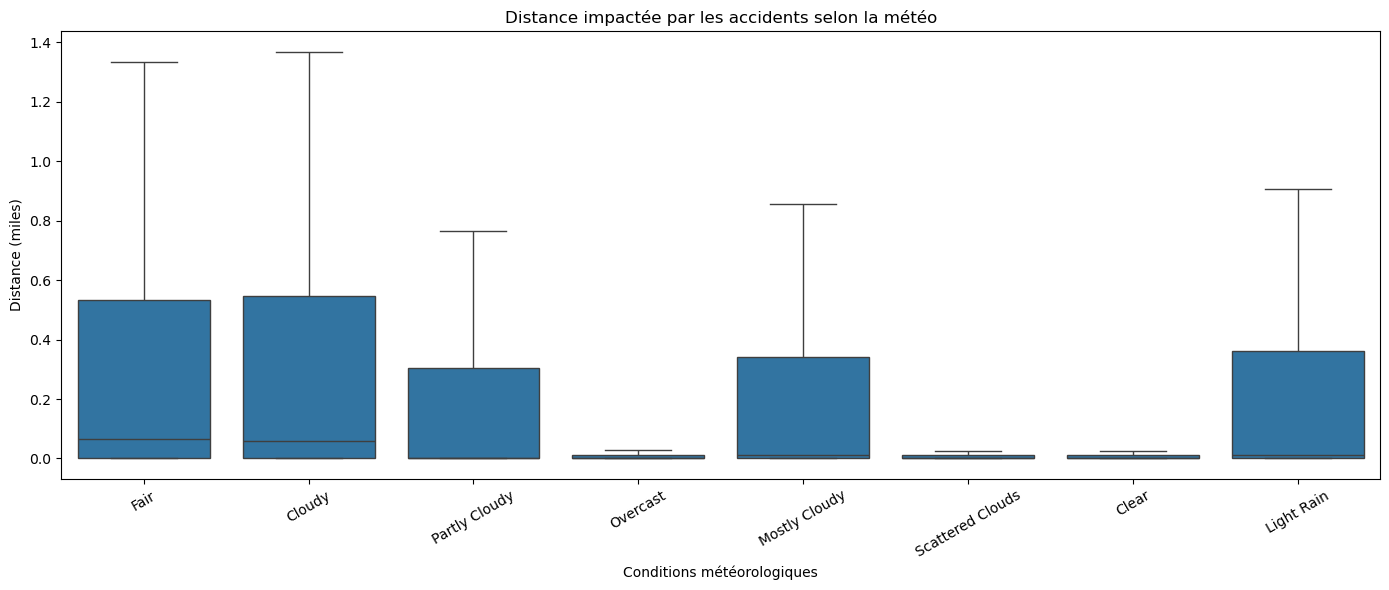

In [14]:
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df_weather.sample(200_000),
    x='Weather',
    y='Distance',
    showfliers=False
)
plt.title("Distance impactée par les accidents selon la météo")
plt.xlabel("Conditions météorologiques")
plt.ylabel("Distance (miles)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Les visualisations montrent que certaines conditions météorologiques sont associées à des distances impactées plus longues, reflétant un impact opérationnel plus important sur le trafic routier.

### Probabilité d’accident grave selon la météo (Régression logistique)

In [17]:
import statsmodels.formula.api as smf
import numpy as np

logit_sample = df_weather.sample(300_000, random_state=42)

logit_model = smf.logit(
    'Severe ~ C(Weather, Treatment(reference="Clear"))',
    data=logit_sample
).fit()

logit_model.summary()



Optimization terminated successfully.
         Current function value: 0.499819
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Severe   No. Observations:               300000
Model:                          Logit   Df Residuals:                   299992
Method:                           MLE   Df Model:                            7
Date:                Fri, 16 Jan 2026   Pseudo R-squ.:                 0.03470
Time:                        13:35:20   Log-Likelihood:            -1.4995e+05
converged:                       True   LL-Null:                   -1.5534e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       -0.6766      0.011    -62.226      0.000      -0.698      -0.655
C(Weather, Treatment(reference="Clear"))[T.Cloudy]              -0.9977      0.018    -53.995      0.000      -1.034      -0.961
C(Weather, Treatment(reference="Clear"))[T.Fair]                -1.1495      0.014    -82.653      0.000      -1.177      -1.122
C(Weather, Treatment(reference="Clear"))[T.Light Rain]          -0.4125      0.022    -19.028      0.000      -0.455      -0.370
C(Weather, Treatment(reference="Clear"))[T.Mostly Cloudy]       -0.5498      0.016    -34.902      0.000      -0.581      -0.519
C(Weather, Treatment(reference="Clear"))[T.Overcast]             0.0630      0.019      3.329      0.001       0.026       0.100
C(Weather, Treatment(reference="Clear"))[T.Partly Cloudy]       -0.5571      0.018    -31.721      0.000      -0.591      -0.523
C(Weather, Treatment(reference="Clear"))[T.Scattered Clouds]     0.0429      0.024      1.793      0.073      -0.004       0.090
================================================================================================================================
"""

La régression logistique montre que certaines conditions météorologiques augmentent significativement la probabilité d’un accident grave.
Les odds ratios supérieurs à 1 confirment un risque relatif accru par rapport aux conditions normales.

### Probabilité moyenne d’accident grave par météo (Visualisation)


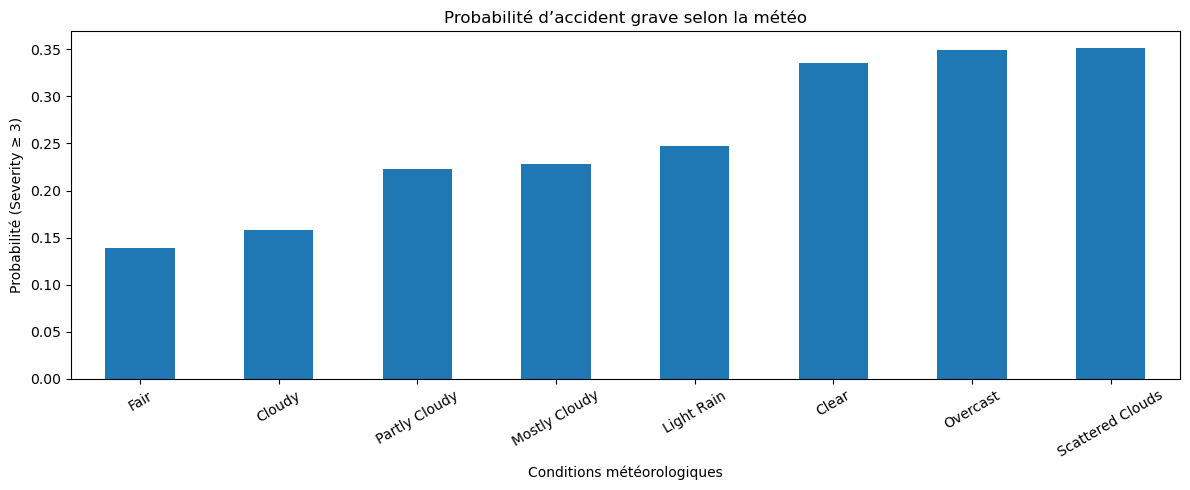

In [16]:
prob_severe = (
    df_weather
    .groupby('Weather')['Severe']
    .mean()
    .sort_values()
)

plt.figure(figsize=(12,5))
prob_severe.plot(kind='bar')
plt.title("Probabilité d’accident grave selon la météo")
plt.xlabel("Conditions météorologiques")
plt.ylabel("Probabilité (Severity ≥ 3)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Cette visualisation met en évidence des écarts clairs de risque entre les conditions météorologiques, confirmant l’existence de profils météo à fort potentiel de danger.